<a href="https://colab.research.google.com/github/jshaam7/ocr-engine-comparison/blob/main/Compare_3_OCR_Engines_on_a_Mortgage_PDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install Dependencies

#tesseract
!apt install tesseract-ocr
!pip install pymupdf pytesseract opencv-python pillow

#paddleocr
!pip uninstall -y paddlepaddle paddleocr
!pip install paddlepaddle==3.2.0
!pip install paddleocr==3.3.0

#easyocr
!pip install easyocr

#general tools for pdf
!pip install pdf2image
!apt-get install poppler-utils -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
Found existing installation: paddlepaddle 3.2.0
Uninstalling paddlepaddle-3.2.0:
  Successfully uninstalled paddlepaddle-3.2.0
Found existing installation: paddleocr 3.3.0
Uninstalling paddleocr-3.3.0:
  Successfully uninstalled paddleocr-3.3.0
  Using cached paddlepaddle-3.2.0-cp312-cp312-manylinux1_x86_64.whl.metadata (8.8 kB)
Using cached paddlepaddle-3.2.0-cp312-cp312-manylinux1_x86_64.whl (189.0 MB)
  Using cached paddleocr-3.3.0-py3-none-any.whl.metadata (34 kB)
Using cached paddleocr-3.3.0-py3-none-any.whl (81 kB)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.12).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


In [3]:
# Environment variable (run before imports)
import os
os.environ['FLAGS_use_mkldnn'] = '0'

# PaddleOCR 3.x pulls in paddlex which internally imports langchain.docstore —
# a module removed in LangChain 0.1+. Mock it here BEFORE Cell 3 runs so the
# import in Cell 3 doesn't raise ModuleNotFoundError.
import sys
from unittest.mock import MagicMock

for _mod in [
    'langchain.docstore',
    'langchain.docstore.document',
    'langchain.text_splitter',
    'langchain_community',
    'langchain_community.document_loaders',
]:
    sys.modules[_mod] = MagicMock()

In [4]:
# Imports
import fitz  # PyMuPDF
import cv2
import pytesseract
import numpy as np
import re
import json
from paddleocr import PaddleOCR
from langchain.docstore.document import Document  # now resolves via the mock above
from PIL import Image, ImageDraw, ImageFont
from google.colab import files
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import easyocr
import io
from IPython import display

Checking connectivity to the model hosters, this may take a while. To bypass this check, set `DISABLE_MODEL_SOURCE_CHECK` to `True`.


In [5]:
uploaded = files.upload()
doc = fitz.open("LenderFeesWorksheetNew.pdf")

Saving LenderFeesWorksheetNew.pdf to LenderFeesWorksheetNew.pdf


In [8]:
from IPython.display import display

## Tesseract OCR

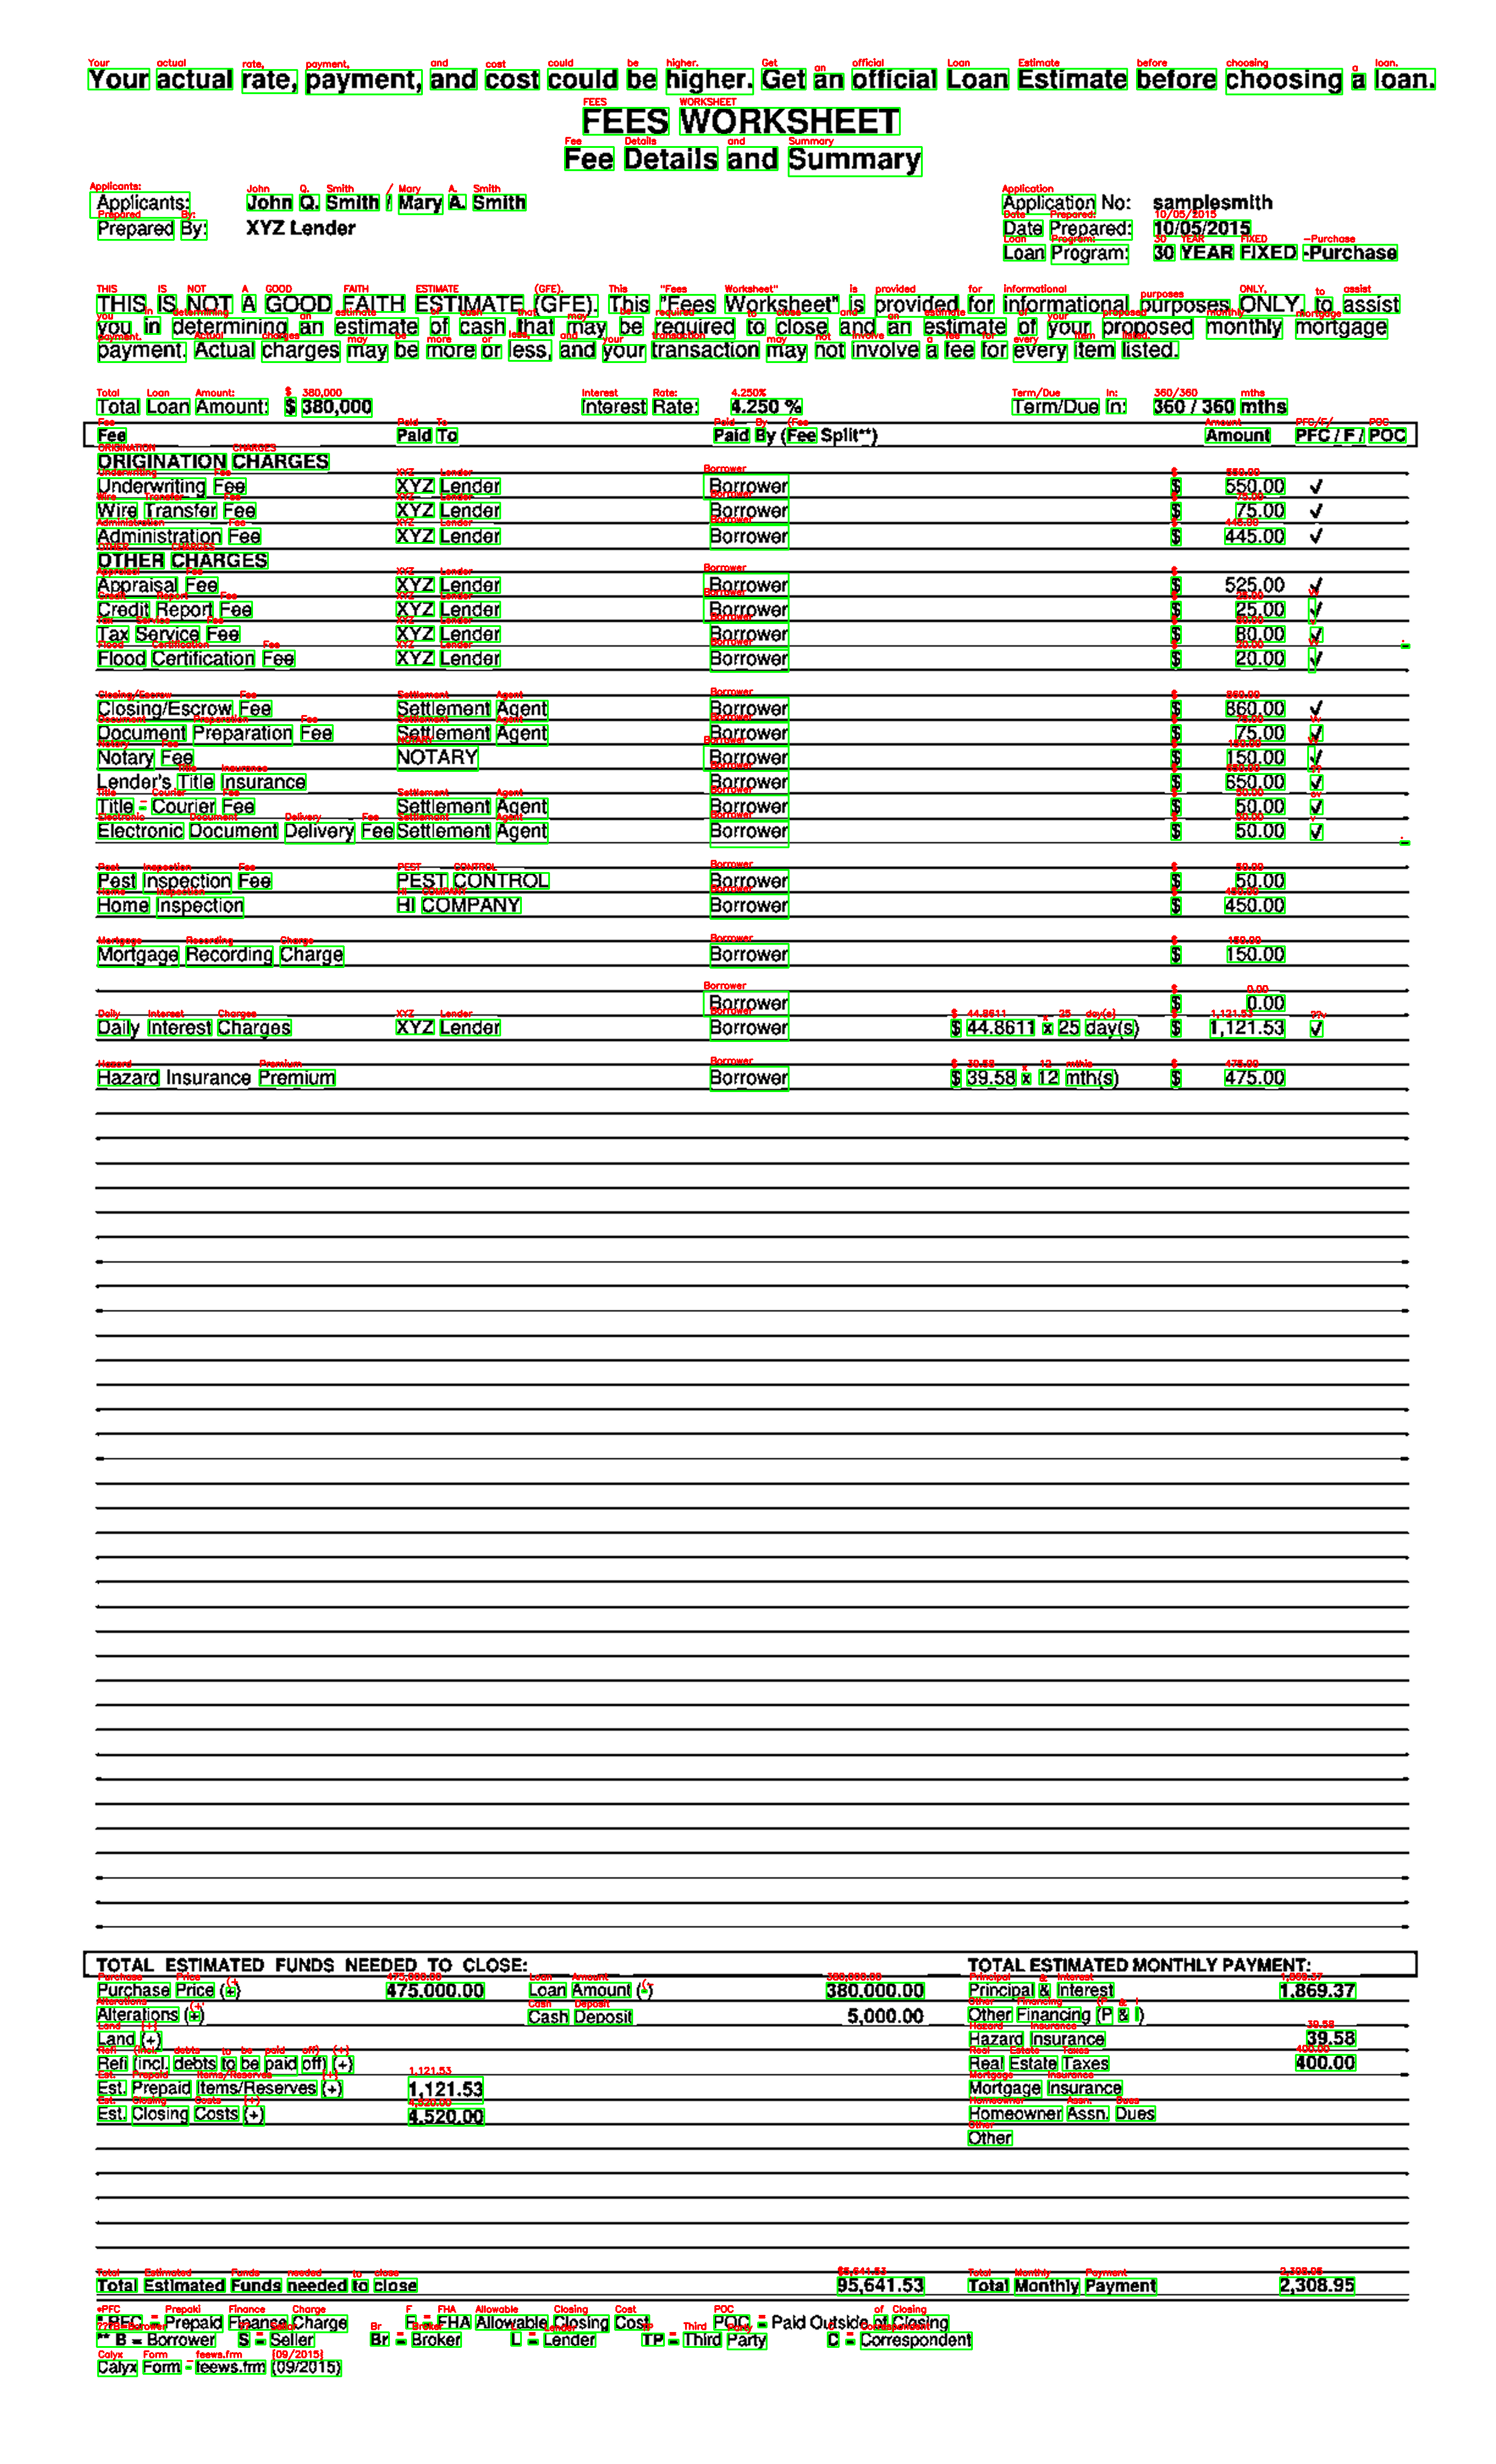

Your actual rate, payment, and cost could be higher. Get an official Loan Estimate before choosing a loan.

FEES WORKSHEET
Fee Details and Summary

Applicants: John Q. Smith / Mary A. Smith Application No: samplesmith
Prepared By: XYZ Lender Date Prepared: 10/05/2015
Loan Program: 30 YEAR FIXED -Purchase

THIS IS NOT A GOOD FAITH ESTIMATE (GFE). This "Fees Worksheet" is provided for informational purposes ONLY, to assist
you in determining an estimate of cash that may be required to close and an estimate of your proposed monthly mortgage
payment. Actual charges may be more or less, and your transaction may not involve a fee for every item listed.

 

 

 

 

 

 

 

 

 

 

 

Total Loan Amount: $ 380,000 Interest Rate: 4.250% Term/Due In: 360/360 mths
Fee Pald To Paid By (Fee Split** Amount PFC/F/ POC
ORIGINATION CHARGES
Underwriting Fee XYZ Lender Borrower $ 550.00 Vv
Wire Transfer Fee XYZ Lender Borrower $ 75.00 Vv
Administration Fee XYZ Lender Borrower $ 445.00 Vv
OTHER CHARGES


In [9]:
page = doc[0]

# Convert PDF Pages to an Image
pre_processed = {}

for page_num in range(len(doc)):
    page = doc[page_num]

    # use matrix for better dpi
    pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))
    img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, 3)

    # Preprocessing for better OCR
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), sigmaX=0.5)
    gray = cv2.adaptiveThreshold( gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 10)

    # Resize image for better OCR accuracy
    gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    pre_processed[page_num] = gray

#Extract Raw Text
custom_config = r'--oem 3 -l eng'
for pg_num, gray in pre_processed.items():
  ocr_text_tesseract = pytesseract.image_to_string(gray, config=custom_config)


#Draw Boundingn Boxes
post_processed = {}

for pg_num, gray in pre_processed.items():
  ocr_data = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)
  img_bgr = cv2.cvtColor(gray, cv2.COLOR_RGB2BGR)
  page_height = gray.shape[0]
  confidence_threshold = 40 # (ignore low-confidence words)

  # Loop through Extracted OCR Words & Draw Bounding Boxes
  for i in range(len(ocr_data["text"])):
      word = ocr_data["text"][i].strip()
      x, y, w, h = ocr_data["left"][i], ocr_data["top"][i], ocr_data["width"][i], ocr_data["height"][i]
      conf = int(ocr_data["conf"][i])  # Convert confidence to int
      # Ignore empty words & low-confidence OCR text
      if not word or conf < confidence_threshold:
          continue

      # Draw bounding box
      cv2.rectangle(img_bgr, (x, y), (x + w, y + h), (0, 255, 0), 2)
      cv2.putText(img_bgr, word, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

      # save data
      post_processed[word] = {
          "text": word,
          "bounding_box": [x, y, w, h]
      }

  # Convert Back to RGB & Display the Image
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  display(Image.fromarray(img_rgb))

json_output_tesseract = json.dumps(post_processed, indent=4)

print(ocr_text_tesseract)

# PaddleOCR

In [10]:
#paddleOCR: convert_pdf_to_images helper
def convert_pdf_to_images(pdf_path, dpi=300):
    try:
        images = convert_from_path(pdf_path, dpi=dpi)
        print(f"✅ Successfully converted {len(images)} page(s)")
        return images
    except Exception as e:
        print(f"❌ Error converting PDF: {e}")
        return []

✅ Successfully converted 1 page(s)


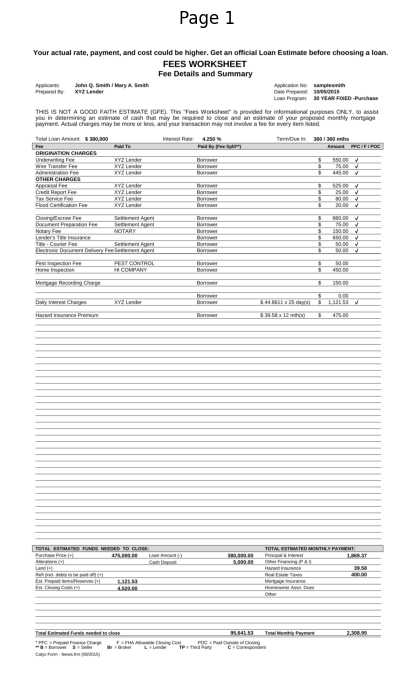

In [11]:
#display images and run OCR
pdf_path = f"/content/LenderFeesWorksheetNew.pdf"
images = convert_pdf_to_images(pdf_path)

if images:
    pages_to_show = min(len(images), 3)  # show first couple pages
    fig, axes = plt.subplots(1, pages_to_show, figsize=(5*pages_to_show, 7))
    if pages_to_show == 1:
        axes = [axes]

    for i in range(pages_to_show):
        axes[i].imshow(images[i])
        axes[i].set_title(f'Page {i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("❌ No images to display")

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/en_PP-OCRv5_mobile_rec`.
/tmp

[0.99] FEES WORKSHEET
[1.00] Fee Details and Summary
[1.00] Applicants:
[0.98] John Q. Smith / Mary A. Smith
[0.97] Application No:
[1.00] Prepared By:
[1.00] samplesmith
[1.00] XYZ Lender
[1.00] Date Prepared:
[1.00] 10/05/2015
[1.00] Loan Program:
[1.00] 30 YEAR FIXED -Purchase
[0.99] THIS IS NOT A GOOD FAITH ESTIMATE (GFE). This "Fees Worksheet" is provided for informational purposes ONLY, to assist
[0.98] you in determining an estimate of cash that may be required to close and an estimate of your proposed monthly mortgage
[0.98] payment. Actual charges may be more or less, and your transaction may not involve a fee for every item listed.
[1.00] Total Loan Amount: $ 380,000
[1.00] Interest Rate:
[0.93] 4.250 %
[0.96] Term/Due In:
[0.97] 360 / 360 mths
[1.00] Fee
[1.00] Paid To
[0.98] Paid By (Fee Split**)
[1.00] Amount
[0.96] PFC/F/POC
[0.97] ORIGINATION CHARGES
[1.00] Underwriting Fee
[1.00] XYZ Lender
[1.00] Borrower
[1.00] $
[1.00] 550.00
[0.71] √
[0.97] Wire Transfer Fee
[1.00] 

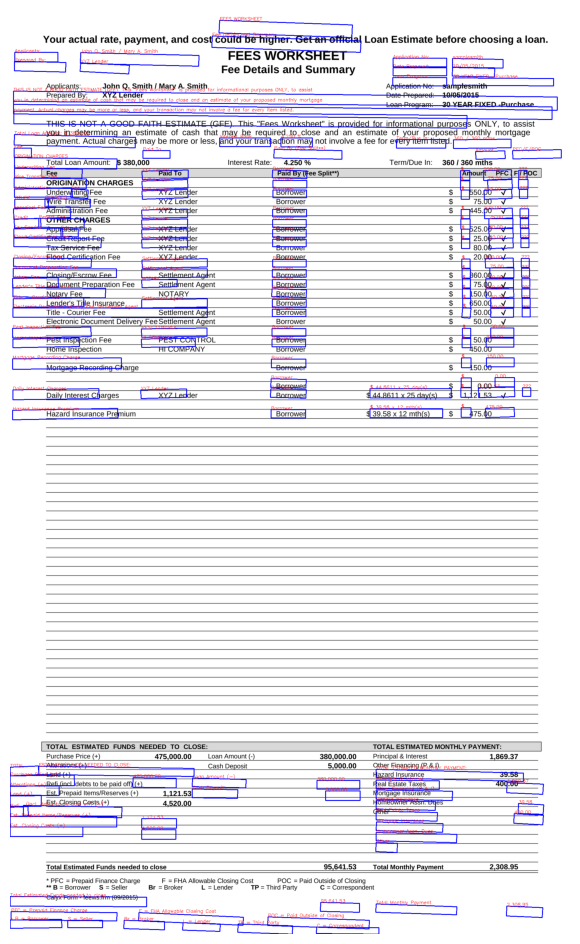

In [15]:
#run OCR and draw bounding boxes
image_path = "page_1.png"

# Resize to stay under PaddleOCR's 4000px side limit before saving
img_pil = images[0]
max_side = 3000
w, h = img_pil.size
if max(w, h) > max_side:
    scale = max_side / max(w, h)
    img_pil = img_pil.resize((int(w * scale), int(h * scale)), Image.LANCZOS)
img_pil.save(image_path, "PNG")

ocr = PaddleOCR(use_textline_orientation=True, lang='en')
result = ocr.ocr(image_path)

# PaddleOCR 3.x returns a list of dicts, not a list of [box, text] pairs
# Use the new format: result[0] is a dict with 'rec_texts', 'rec_scores', 'rec_polys'
if isinstance(result[0], dict):
    texts  = result[0]['rec_texts']
    scores = result[0]['rec_scores']
    boxes  = result[0]['rec_polys']
else:
    # fallback for older format
    texts  = [line[1][0] for line in result[0]]
    scores = [line[1][1] for line in result[0]]
    boxes  = [line[0]    for line in result[0]]

# Print extracted text
for text, score in zip(texts, scores):
    print(f"[{score:.2f}] {text}")

# Draw bounding boxes
img = cv2.imread(image_path)

for box, text, score in zip(boxes, texts, scores):
    box = [(int(pt[0]), int(pt[1])) for pt in box]
    cv2.polylines(img, [np.array(box)], isClosed=True, color=(255, 0, 0), thickness=2)
    cv2.putText(img, text, box[0], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

# EasyOCR

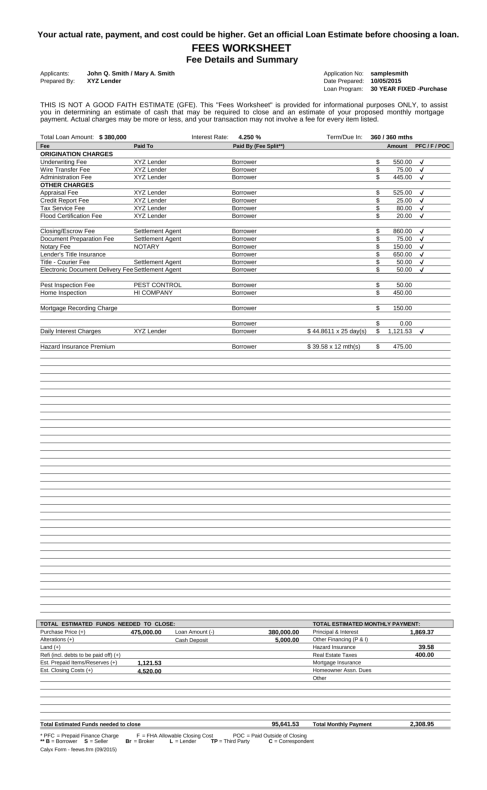

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


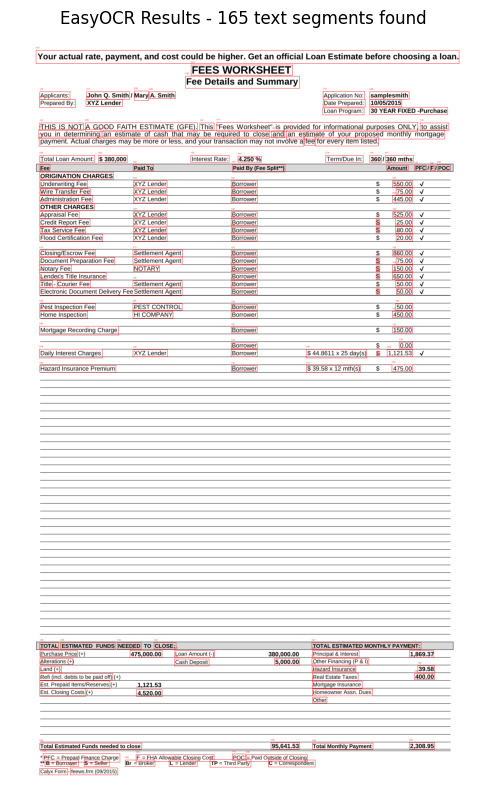

In [16]:
pdf_path = f"/content/LenderFeesWorksheetNew.pdf"
images = convert_from_path(pdf_path, dpi=300)

image = images[0]  # Use first page
# Save image as file (EasyOCR works better with file paths)
image_path = '/content/easyocr_doc.png'
image.save(image_path)

# Show uploaded image
plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

reader = easyocr.Reader(['en'])
result = reader.readtext(image_path)

# Draw Bounding Boxes
img_copy = image.copy()
draw = ImageDraw.Draw(img_copy)
extracted_text = []

for (bbox, text, confidence) in result:
    if confidence > 0.5:  # Filter by confidence
        # Draw bounding box
        top_left = tuple(map(int, bbox[0]))
        bottom_right = tuple(map(int, bbox[2]))
        draw.rectangle([top_left, bottom_right], outline='red', width=2)

        # Add confidence score
        draw.text((top_left[0], top_left[1]-20), f"{confidence:.2f}", fill='red')

        extracted_text.append(text)

# Display results
plt.figure(figsize=(15, 10))
plt.imshow(img_copy)
plt.title(f'EasyOCR Results - {len(extracted_text)} text segments found')
plt.axis('off')
plt.show()